In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jeffreyjoan
Your Kaggle Key: ··········


100%|██████████| 86.8M/86.8M [00:04<00:00, 18.4MB/s]


In [ ]:
ls

brain-tumor-classification-mri/  drive/  sample_data/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/brain-tumor-classification-mri'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


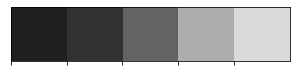

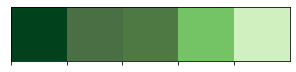

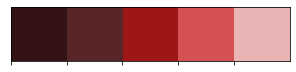

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('./brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('./brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 192.62it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
with strategy.scope():
  inc_model = tf.keras.applications.InceptionV3(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

In [ ]:
with strategy.scope():
  model = inc_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=inc_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_inc.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.7730
Epoch 1: val_accuracy improved from -inf to 0.27891, saving model to brain_tumor_inc.h5
83/83 [==============================] - 29s 163ms/step - loss: 0.6153 - accuracy: 0.7730 - val_loss: 14.6361 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8888
Epoch 2: val_accuracy improved from 0.27891 to 0.74490, saving model to brain_tumor_inc.h5
83/83 [==============================] - 12s 140ms/step - loss: 0.3380 - accuracy: 0.8888 - val_loss: 1.7194 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9285
Epoch 3: val_accuracy did not improve from 0.74490
83/83 [==============================] - 9s 113ms/step - loss: 0.2118 - accuracy: 0.9285 - val_loss: 1.8129 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - ETA: 

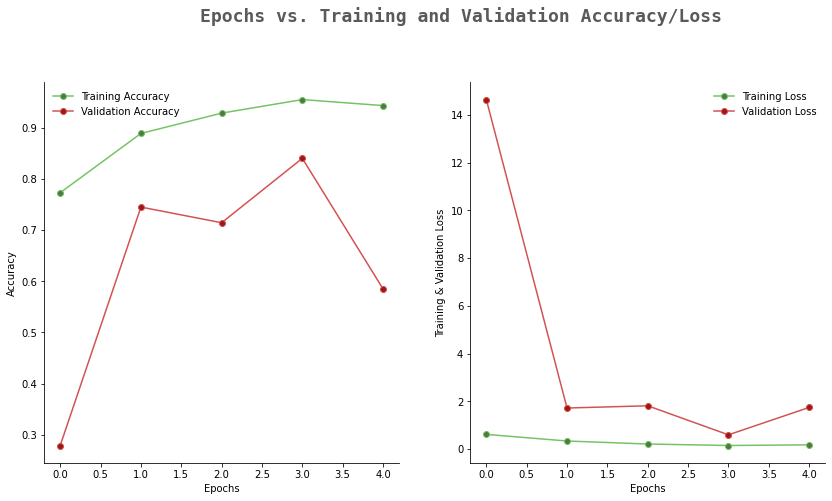

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 39ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.93      0.14      0.24       100
           1       0.26      1.00      0.42        48
           2       0.89      0.72      0.80        93
           3       1.00      0.63      0.77        86

    accuracy                           0.56       327
   macro avg       0.77      0.62      0.56       327
weighted avg       0.84      0.56      0.57       327



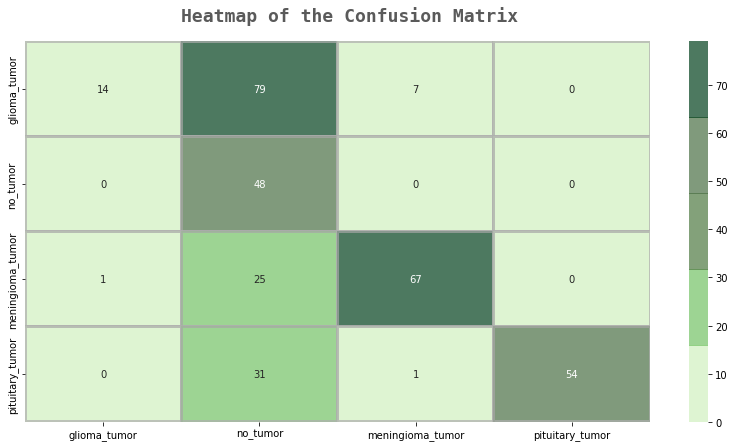

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
with strategy.scope():
  Xcep_model = tf.keras.applications.Xception(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
with strategy.scope():
  model = Xcep_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=Xcep_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_xcep.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.8278
Epoch 1: val_accuracy improved from -inf to 0.69048, saving model to brain_tumor_xcep.h5
83/83 [==============================] - 40s 343ms/step - loss: 0.4914 - accuracy: 0.8278 - val_loss: 1.6040 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9285
Epoch 2: val_accuracy improved from 0.69048 to 0.82993, saving model to brain_tumor_xcep.h5
83/83 [==============================] - 25s 296ms/step - loss: 0.2283 - accuracy: 0.9285 - val_loss: 0.7194 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9519
Epoch 3: val_accuracy improved from 0.82993 to 0.91156, saving model to brain_tumor_xcep.h5
83/83 [==============================] - 24s 291ms/step - loss: 0.1434 - accuracy: 0.9519 - val_loss: 0.5811 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 4/5
83/

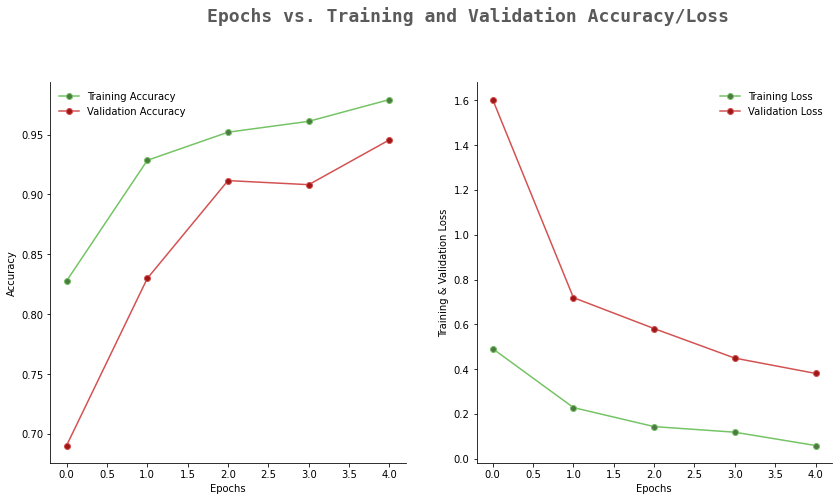

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 115ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       100
           1       0.98      0.96      0.97        48
           2       0.84      0.94      0.89        93
           3       0.90      0.97      0.93        86

    accuracy                           0.92       327
   macro avg       0.93      0.92      0.92       327
weighted avg       0.92      0.92      0.92       327



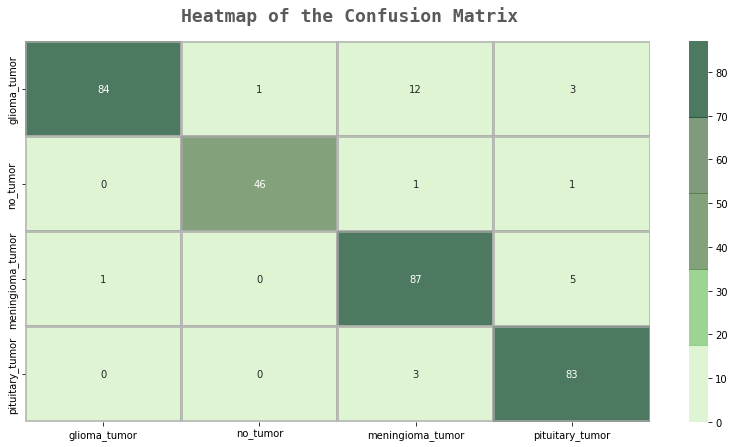

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
with strategy.scope():
  vgg16_model = tf.keras.applications.VGG16(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
with strategy.scope():
  model = vgg16_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=vgg16_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_vgg.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 1.3337 - accuracy: 0.3594
Epoch 1: val_accuracy improved from -inf to 0.37755, saving model to brain_tumor_vgg.h5
83/83 [==============================] - 22s 229ms/step - loss: 1.3337 - accuracy: 0.3594 - val_loss: 1.3288 - val_accuracy: 0.3776 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 1.3907 - accuracy: 0.3224
Epoch 2: val_accuracy improved from 0.37755 to 0.46259, saving model to brain_tumor_vgg.h5
83/83 [==============================] - 18s 216ms/step - loss: 1.3907 - accuracy: 0.3224 - val_loss: 1.2652 - val_accuracy: 0.4626 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 1.2931 - accuracy: 0.3958
Epoch 3: val_accuracy did not improve from 0.46259
83/83 [==============================] - 17s 210ms/step - loss: 1.2931 - accuracy: 0.3958 - val_loss: 1.2394 - val_accuracy: 0.4082 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - ETA: 

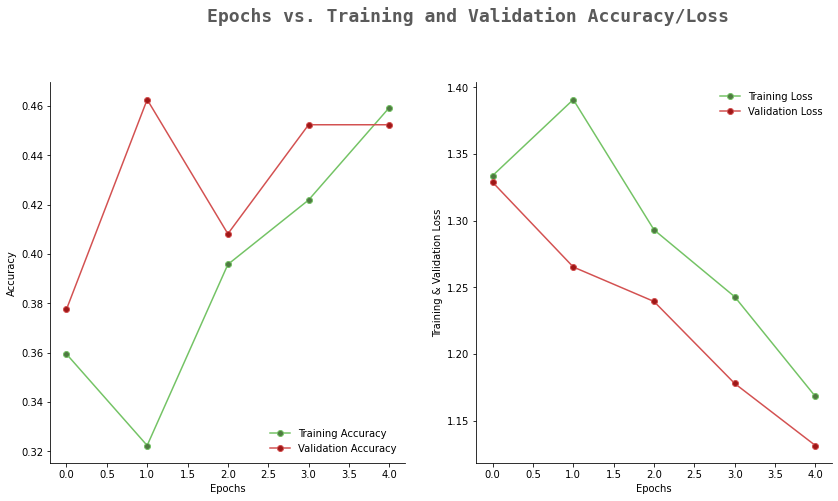

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 2s 71ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.46      0.31      0.37       100
           1       0.00      0.00      0.00        48
           2       0.43      0.44      0.43        93
           3       0.42      0.79      0.55        86

    accuracy                           0.43       327
   macro avg       0.33      0.39      0.34       327
weighted avg       0.37      0.43      0.38       327



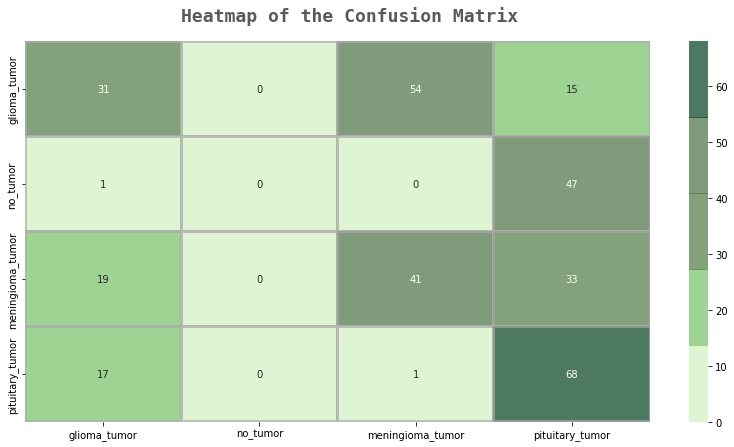

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
with strategy.scope():
  resnet_model = tf.keras.applications.ResNet50(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
with strategy.scope():
  model = resnet_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=resnet_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_resnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.7268
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to brain_tumor_resnet.h5
83/83 [==============================] - 32s 252ms/step - loss: 0.9009 - accuracy: 0.7268 - val_loss: 396.9740 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8702
Epoch 2: val_accuracy improved from 0.33333 to 0.61565, saving model to brain_tumor_resnet.h5
83/83 [==============================] - 17s 206ms/step - loss: 0.3802 - accuracy: 0.8702 - val_loss: 1.5564 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.9285
Epoch 3: val_accuracy improved from 0.61565 to 0.73129, saving model to brain_tumor_resnet.h5
83/83 [==============================] - 17s 205ms/step - loss: 0.2034 - accuracy: 0.9285 - val_loss: 0.7456 - val_accuracy: 0.7313 - lr: 0.0010
Epoch

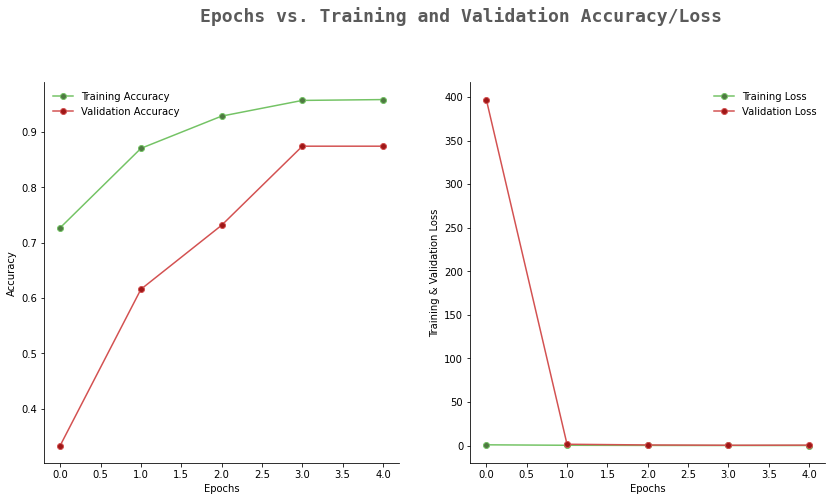

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 95ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       100
           1       0.85      0.94      0.89        48
           2       0.91      0.81      0.86        93
           3       0.95      0.94      0.95        86

    accuracy                           0.91       327
   macro avg       0.90      0.91      0.90       327
weighted avg       0.91      0.91      0.90       327



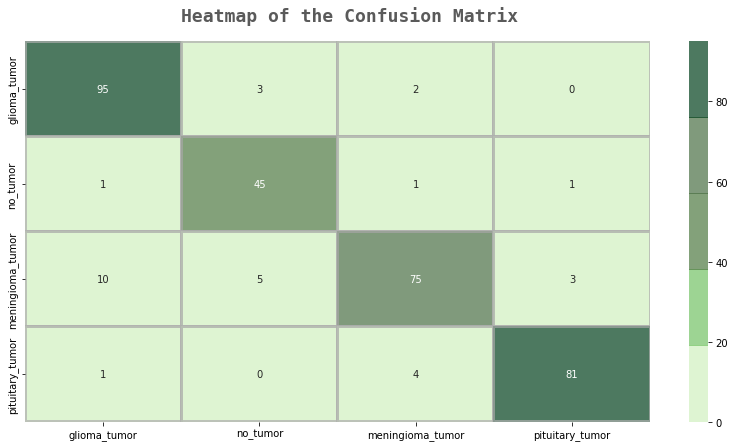

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
with strategy.scope():
  inc_res_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
with strategy.scope():
  model = inc_res_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=inc_res_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_inc_res.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.8078
Epoch 1: val_accuracy improved from -inf to 0.48980, saving model to brain_tumor_inc_res.h5
83/83 [==============================] - 65s 389ms/step - loss: 0.6228 - accuracy: 0.8078 - val_loss: 25.1374 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9387
Epoch 2: val_accuracy improved from 0.48980 to 0.85034, saving model to brain_tumor_inc_res.h5
83/83 [==============================] - 27s 320ms/step - loss: 0.1663 - accuracy: 0.9387 - val_loss: 0.5634 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.9701
Epoch 3: val_accuracy improved from 0.85034 to 0.93537, saving model to brain_tumor_inc_res.h5
83/83 [==============================] - 27s 319ms/step - loss: 0.0908 - accuracy: 0.9701 - val_loss: 0.1818 - val_accuracy: 0.9354 - lr: 0.0010
Epo

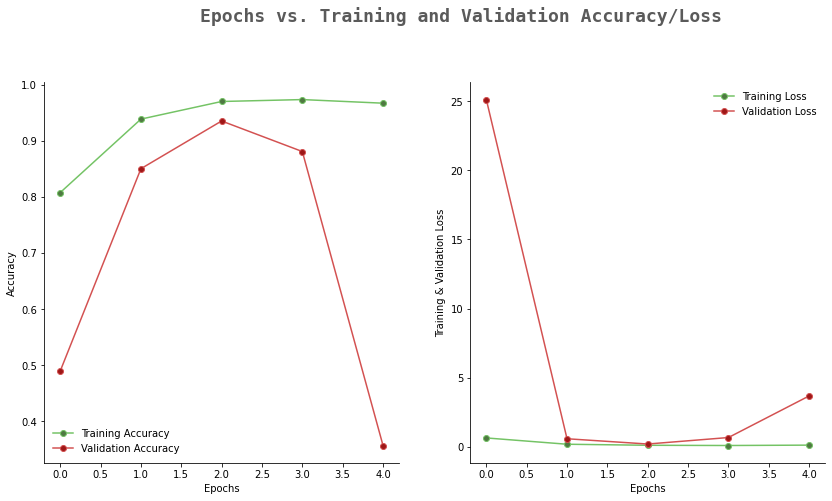

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 6s 125ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       100
           1       0.19      1.00      0.32        48
           2       0.91      0.67      0.77        93
           3       1.00      0.02      0.05        86

    accuracy                           0.35       327
   macro avg       0.77      0.42      0.29       327
weighted avg       0.86      0.35      0.28       327



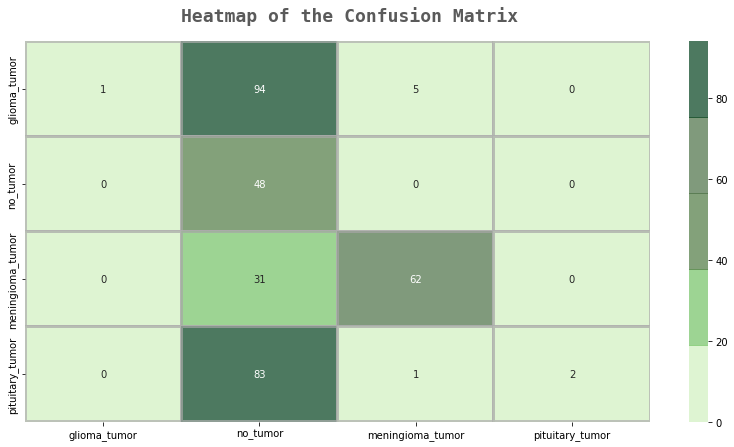

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
with strategy.scope():
  dense_model = tf.keras.applications.DenseNet169(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

51877672/51877672 [==============================] - 3s 0us/step


In [ ]:
with strategy.scope():
  model = dense_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=dense_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_dense.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.7843
Epoch 1: val_accuracy improved from -inf to 0.52381, saving model to brain_tumor_dense.h5
83/83 [==============================] - 60s 358ms/step - loss: 0.6366 - accuracy: 0.7843 - val_loss: 4.5331 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8880
Epoch 2: val_accuracy improved from 0.52381 to 0.61565, saving model to brain_tumor_dense.h5
83/83 [==============================] - 21s 251ms/step - loss: 0.3292 - accuracy: 0.8880 - val_loss: 1.6815 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9073
Epoch 3: val_accuracy improved from 0.61565 to 0.67347, saving model to brain_tumor_dense.h5
83/83 [==============================] - 22s 261ms/step - loss: 0.2760 - accuracy: 0.9073 - val_loss: 2.0841 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 4/5


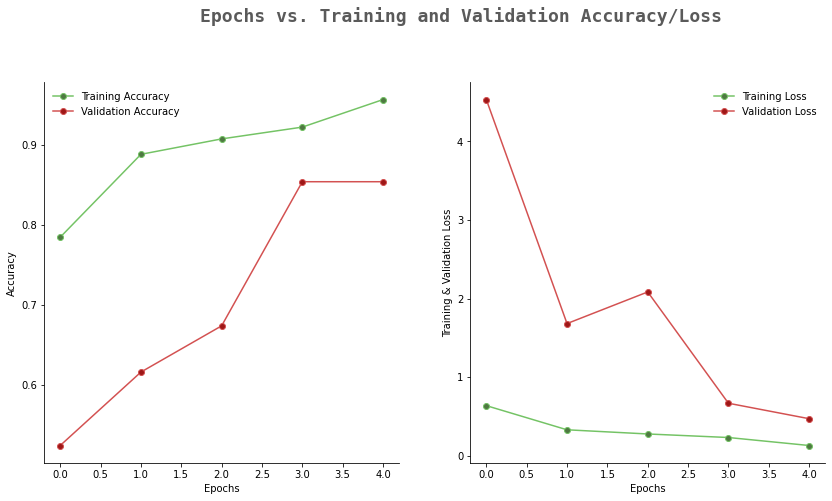

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 6s 195ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74       100
           1       0.53      0.98      0.69        48
           2       0.86      0.94      0.90        93
           3       0.96      0.84      0.89        86

    accuracy                           0.81       327
   macro avg       0.83      0.84      0.80       327
weighted avg       0.87      0.81      0.82       327



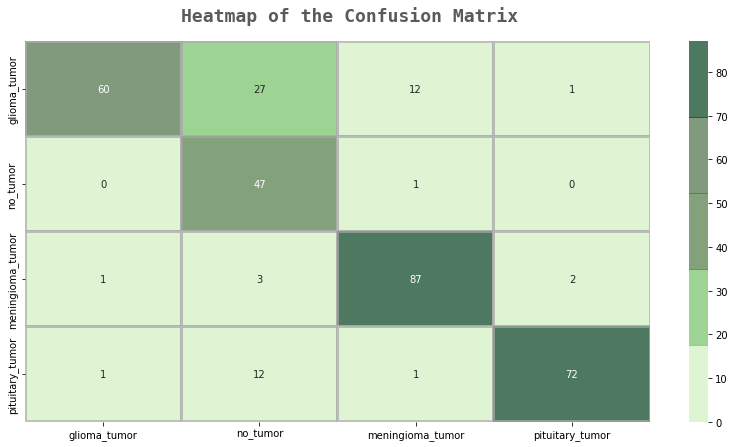

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
with strategy.scope():
  efnet_model = tf.keras.applications.EfficientNetB7(include_top=False,
                                                input_shape=(150, 150, 3),
                                                weights='imagenet')

258076736/258076736 [==============================] - 13s 0us/step


In [ ]:
with strategy.scope():
  model = efnet_model.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=efnet_model.input, outputs = model)

In [ ]:
with strategy.scope():
  model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tumor_effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
with strategy.scope():
  history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.8142
Epoch 1: val_accuracy improved from -inf to 0.75850, saving model to brain_tumor_effnet.h5
83/83 [==============================] - 134s 1s/step - loss: 0.5447 - accuracy: 0.8142 - val_loss: 2.4027 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9168
Epoch 2: val_accuracy improved from 0.75850 to 0.92517, saving model to brain_tumor_effnet.h5
83/83 [==============================] - 81s 978ms/step - loss: 0.2465 - accuracy: 0.9168 - val_loss: 0.3040 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.9580
Epoch 3: val_accuracy did not improve from 0.92517
83/83 [==============================] - 76s 917ms/step - loss: 0.1389 - accuracy: 0.9580 - val_loss: 0.8027 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - E

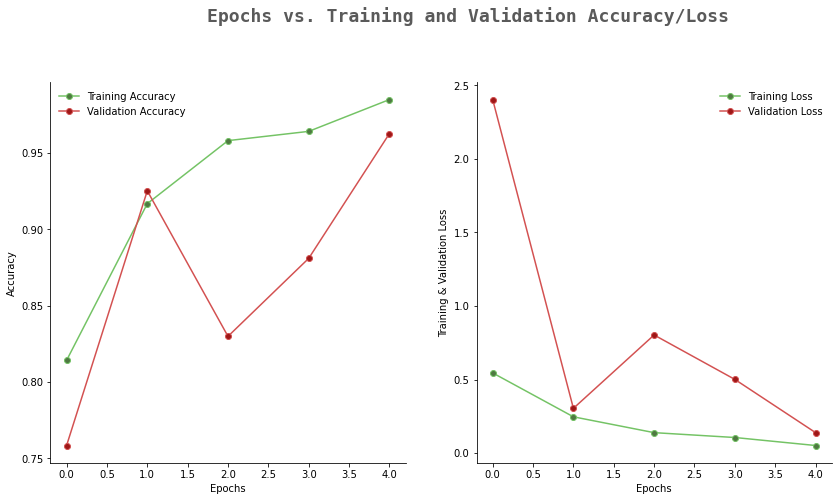

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 10s 255ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       100
           1       1.00      0.98      0.99        48
           2       0.93      0.96      0.94        93
           3       0.98      1.00      0.99        86

    accuracy                           0.96       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.96      0.96      0.96       327



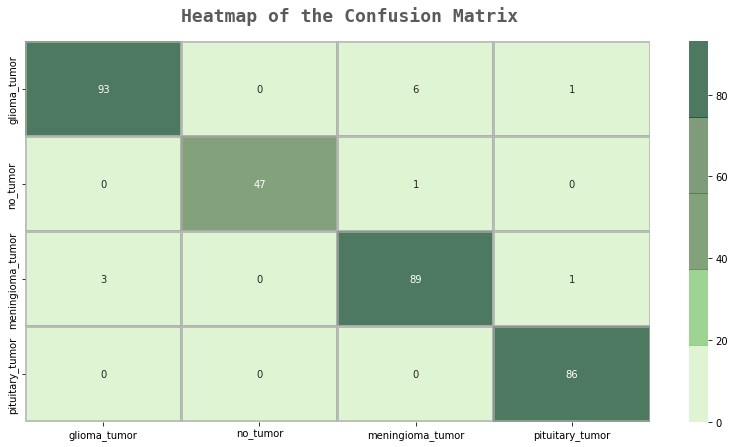

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()